In [25]:
%load_ext autoreload
%autoreload 2

import copy
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.figure import Figure

from multiprocessing import Pool
import time
from tqdm import tqdm
import networkx as nx



from graph_generation import GenerateGraph, perturb_nx_graph
from models import GCN, view_parameters, new_parameters, modify_parameters, Inits
from train import Trainer, Dataset
from embedding import Embedding, NodeEmbedding
import experiments
from experiments import (init_GCN, init, init_model_dataset, experiment_node_embedding, 
                         elaborate_embeddings, elaborate_embeddings_2, elaborate_embedding_pergraph, separate_embedding_by_classes,
                         run_with_weights, init_with_weights, make_video, take_corr, plot_epoch, get_corrs_training)
from config_valid import Config, TrainingMode
from plot_model import plot_model
from plot_funcs import (plot_dim1, plot_dimN, plot_correlation_error, get_metrics, plot_node_emb_1D_perclass, scatter_node_emb, 
                        plot_graph_emb_1D, plot_data_degree_sequence)
from utils import array_wo_outliers, plot_grafo, plot_grafo2
from Inspect import Inspect


import torch
from torch_geometric import nn
from torch_geometric.loader import DataLoader
device = torch.device('cuda')

from scipy import stats
from sklearn.metrics import log_loss

import pickle 
from plt_parameters import init_params
init_params()

#from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
#event_acc = EventAccumulator(path="./runs/lr-0.01_epochs45_bs150_neurons-1-8-2_15Sep_16-15-16")
#event_acc.Reload()
# Show all tags in the log file
#print(event_acc.Tags())
#w_times, step_nums, vals = zip(*event_acc.Scalars('Test Loss'))

def hide_code_in_slideshow():   
    from IPython import display
    import binascii
    import os
    uid = binascii.hexlify(os.urandom(8)).decode()    
    html = """<div id="%s"></div>
    <script type="text/javascript">
        $(function(){
            var p = $("#%s");
            if (p.length==0) return;
            while (!p.hasClass("cell")) {
                p=p.parent();
                if (p.prop("tagName") =="body") return;
            }
            var cell = p;
            cell.find(".input").addClass("hide-in-slideshow")
        });
    </script>""" % (uid, uid)
    display.display_html(html, raw=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
config_file = "configurations/classification_cm.yml"
config_c = Config(config_file)

In [23]:
def start_from_saved_dataset_parameters():
    with open('init_parameters.pickle', 'rb') as file:
        previous_par = pickle.load(file)
    with open('dataset.pickle', 'rb') as file:
        dataset = pickle.load(file)

    config_file = "configurations/classification_cm.yml"
    config_c = Config(config_file)
    #config_c.conf['model']['freezeGCNlayers'] = True

    model = init_GCN(config_c, verbose=False)
    modify_parameters(model, previous_par)

    trainer = Trainer(model, config_c)
    trainer.load_dataset(dataset, percentage_train=config_c.conf['training']['percentage_train'], shuffle=False, parallel=False)
    return trainer, config_c

trainer, config_c = start_from_saved_dataset_parameters()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:12<00:00, 33.00it/s]


Tempo impiegato: 12.1589515209198


In [24]:
trainer.launch_training()
#all_data_loader = DataLoader(trainer.dataset.dataset_pyg, batch_size=trainer.dataset.bs, shuffle=False)
#graph_embeddings_array, node_embeddings_array, node_embeddings_array_id = trainer.take_embedding(all_data_loader)

In [28]:
epoca=180
graph_embeddings_array = trainer.graph_embedding_per_epoch[epoca]
node_embeddings_array = trainer.node_embedding_per_epoch[epoca]

In [29]:
node_emb_pergraph, node_embedding_class = elaborate_embedding_pergraph(config_c, graph_embeddings_array, node_embeddings_array, [], trainer)
emb_perclass0, emb_perclass1 = separate_embedding_by_classes(node_emb_pergraph)

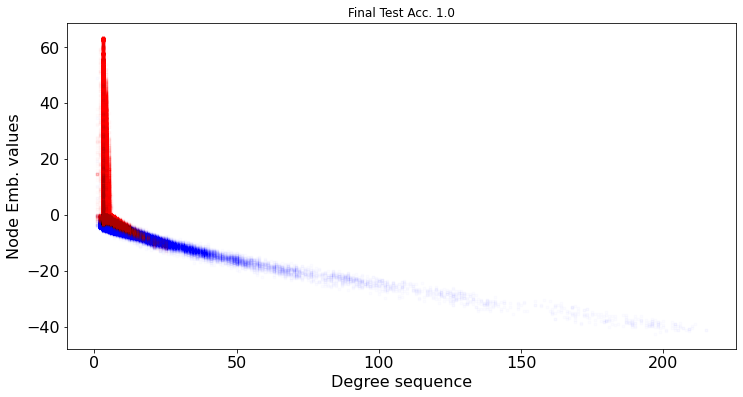

In [30]:
scatter_node_emb(emb_perclass0, emb_perclass1, trainer.last_accuracy)

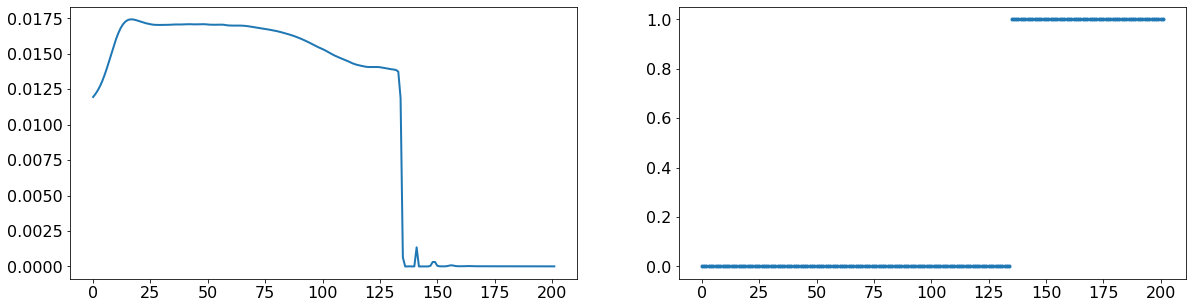

In [31]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,5))
ax1.plot(trainer.test_loss_list)
ax2.plot(trainer.accuracy_list, '.')

# Prova con più layer sperando che la correlazione non si abbassi

In [3]:
dataset, model, trainer, config_c = init(config_file)

Create dataset
Generating dataset...
Dataset generated
Initialize model


In [4]:
trainer.load_dataset(dataset, percentage_train=config_c.conf['training']['percentage_train'], parallel=False)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:12<00:00, 32.59it/s]


Tempo impiegato: 12.323081731796265


In [6]:
trainer.launch_training()

In [19]:
epoca=300
graph_embeddings_array = trainer.graph_embedding_per_epoch[epoca]
node_embeddings_array = trainer.node_embedding_per_epoch[epoca]
node_emb_pergraph, node_embedding_class = elaborate_embedding_pergraph(config_c, graph_embeddings_array, node_embeddings_array, [], trainer)
emb_perclass0, emb_perclass1 = separate_embedding_by_classes(node_emb_pergraph)

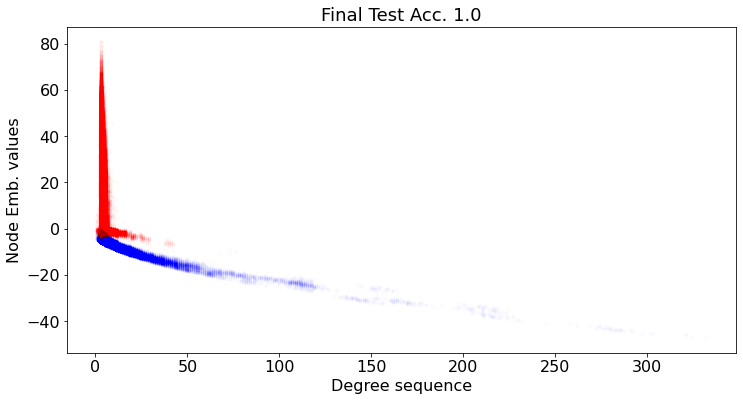

In [20]:
scatter_node_emb(emb_perclass0, emb_perclass1, trainer.last_accuracy)

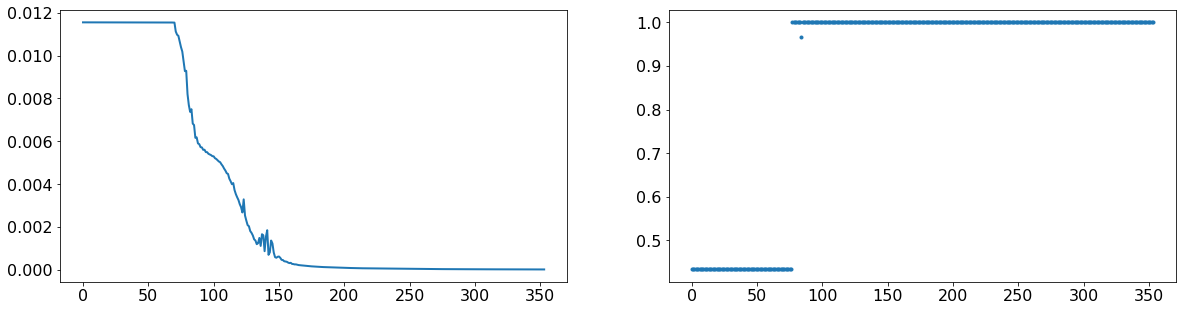

In [16]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,5))
ax1.plot(trainer.test_loss_list)
ax2.plot(trainer.accuracy_list, '.')

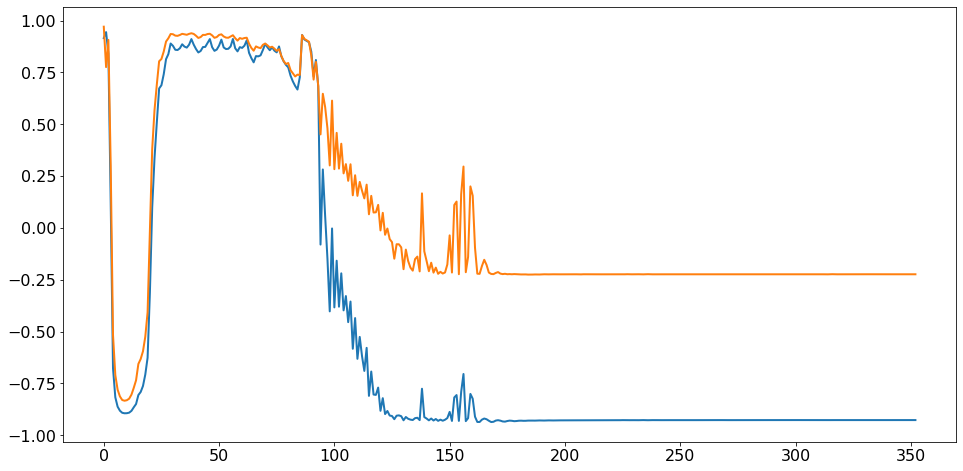

In [12]:
c_e_0, c_e_1 = get_corrs_training()
plt.plot(c_e_0[0])
plt.plot(c_e_1[0])

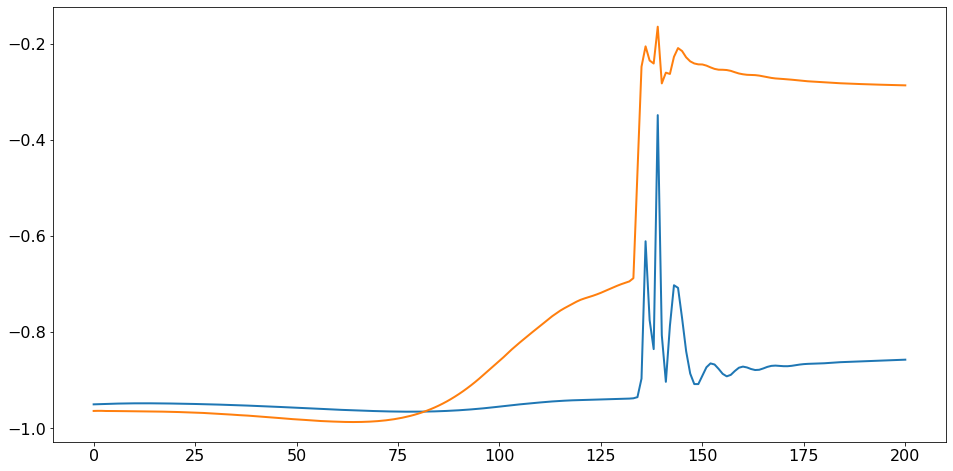

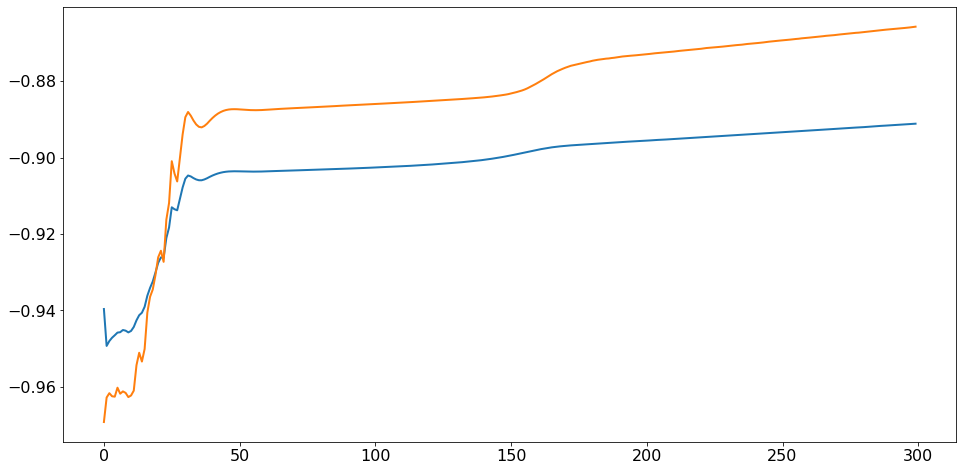

# Vario i neuroni per layer

In [14]:
list_GCNneurons_per_layer = [ [1, 16, 16, 1], 
                             [1, 8, 8, 1],
                             [1, 4, 4, 1],
                             [1, 2, 2, 1]]
list_neurons_last_linear = [[2,1],[2,2,1], [5, 3, 1], [10,10,1]]
trials = list(itertools.product(list_GCNneurons_per_layer, list_neurons_last_linear))
trials = list_neurons_last_linear
trials

[[2, 1], [2, 2, 1], [5, 3, 1], [10, 10, 1]]

In [18]:
def make_config(config, trials):
    configs = []
    # for lr, layer, num_nodes in trials:
    for neurons_last_linear in trials:
        #config['model']['GCNneurons_per_layer'] = GCNneurons_per_layer
        config['model']['neurons_last_linear'] = neurons_last_linear
        copia = copy.deepcopy(config)
        confclass = Config.fromdict(copia)
        configs.append(confclass)
    return configs

config_c = Config(config_file)
configs = make_config(config_c.conf, trials)

In [19]:
model = init_GCN(configs[0], verbose=False)

In [20]:
new_par = new_parameters(model, method=Inits.xavier_uniform)

#modify_parameters(model, new_par)

In [21]:
with open('init_parameters.pickle', 'rb') as file:
    previous_par = pickle.load(file)
with open('dataset.pickle', 'rb') as file:
    dataset = pickle.load(file)
        
for i, c in enumerate(configs):
    print(f'Run {i+1}/{len(configs)}')
    print(c.conf)
    try:       
        init_with_weights(c, new_par, trainer)
        trainer.launch_training()
        c_e_0, c_e_1 = get_corrs_training()
    
        c.conf['test_loss'] = trainer.test_loss_list
        c.conf['test_accuracy'] = trainer.accuracy_list
        c.conf['correlation_class0'] = c_e_0[0]
        c.conf['correlation_class1'] = c_e_1[0]

    except Exception as e: 
        print(repr(e))
        raise(e)

Run 1/4
{'graph_dataset': {'ERmodel': False, 'regular': False, 'confmodel': True, 'continuous_p': True, 'list_p': [0.05, 0.3], 'range_p': [0.05, 0.6], 'Num_nodes': [700, 700], 'Num_grafi_per_tipo': 200, 'Num_grafi_totali': 400, 'list_degree': [4, 50], 'random_node_feat': False, 'list_exponents': [-2.5, -4.5]}, 'training': {'mode': 'mode2', 'learning_rate': 0.1, 'epochs': 500, 'batch_size': 100, 'percentage_train': 0.7, 'earlystop_patience': 50, 'epochs_model_checkpoint': [-1], 'every_epoch_embedding': True}, 'model': {'last_layer_dense': True, 'GCNneurons_per_layer': [1, 4, 4, 1], 'neurons_last_linear': [2, 1], 'freezeGCNlayers': False, 'autoencoder': False, 'put_batchnorm': False, 'put_dropout': False, 'final_pool_aggregator': True, 'node_features_dim': 1}, 'logging': {'train_step_print': 100}, 'device': 'gpu'}
Before training Test loss: 0.011226426561673481
Before training Training + Test loss: 0.023901110390822093
Run training for 500 epochs
Early stopping!!!
Epoch: 346	Test loss: 1

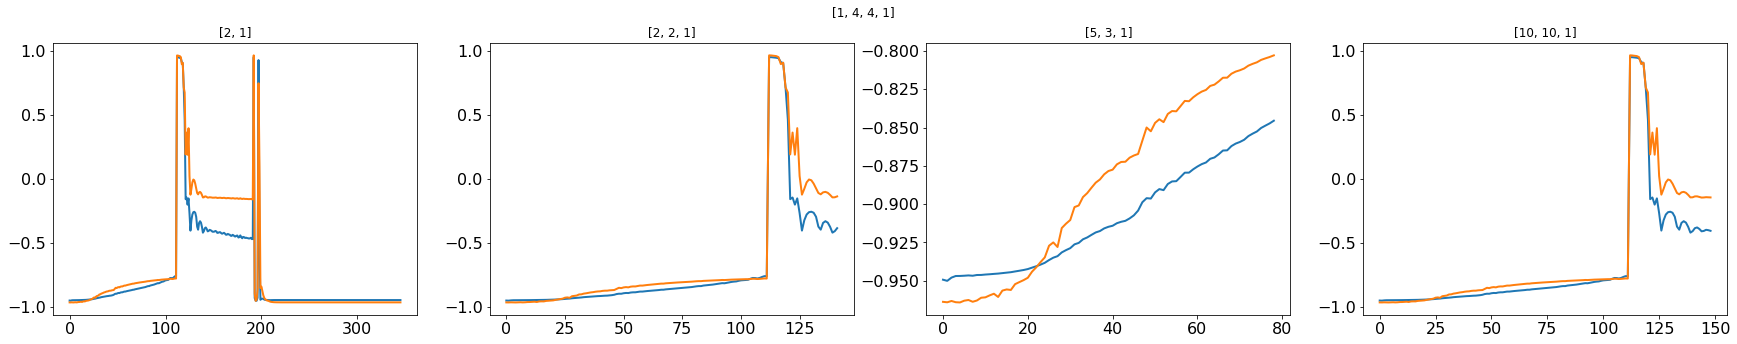

In [22]:
fig, axs = plt.subplots(1,4,figsize=(30,5))
for i, c in enumerate(configs[:4]):
    c_e_0 = c.conf['correlation_class0']
    axs[i].plot(c_e_0)
    c_e_1 = c.conf['correlation_class1']
    axs[i].plot(c_e_1)
    axs[i].set_title(c.conf['model']['neurons_last_linear'])
plt.suptitle(c.conf['model']['GCNneurons_per_layer'])
plt.savefig("correlation_vs_epochs_layers_2b.png")
plt.show()

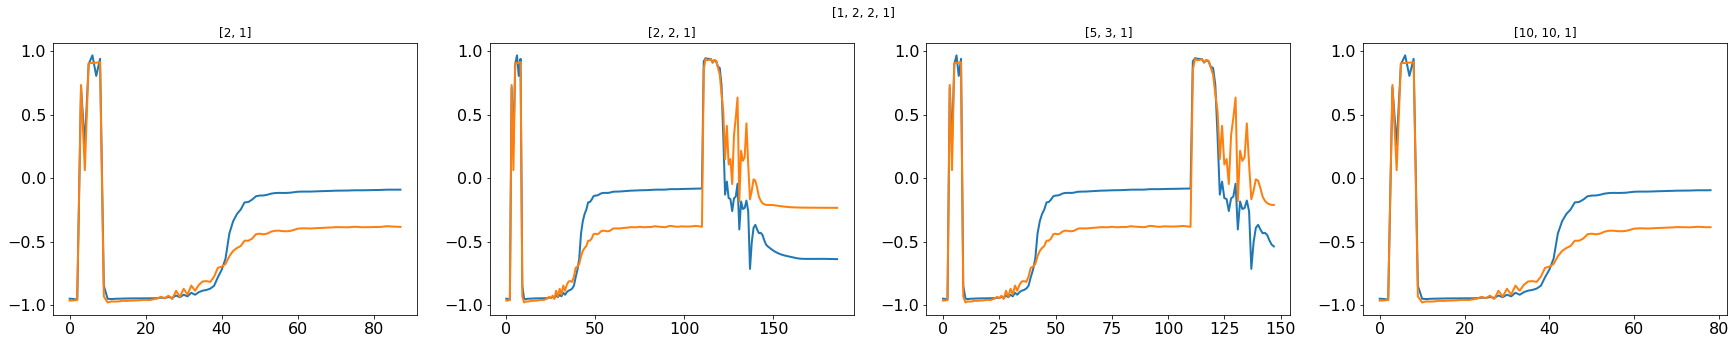

# Vario numero di grafi

In [25]:
trials = [200, 120, 50, 20]
def make_config(config, trials):
    configs = []
    # for lr, layer, num_nodes in trials:
    for Num_grafi_per_tipo in trials:
        config['graph_dataset']['Num_grafi_per_tipo'] = Num_grafi_per_tipo
        copia = copy.deepcopy(config)
        confclass = Config.fromdict(copia)
        configs.append(confclass)
    return configs

config_c = Config(config_file)
configs = make_config(config_c.conf, trials)

In [26]:
with open('init_parameters.pickle', 'rb') as file:
    previous_par = pickle.load(file)
#with open('dataset.pickle', 'rb') as file:
#    dataset = pickle.load(file)
        
for i, c in enumerate(configs):
    print(f'Run {i+1}/{len(configs)}')
    try:       
        model = init_GCN(config_c, verbose=False)
        modify_parameters(model, previous_par)
        gg = GenerateGraph(config_c)
        dataset = gg.initialize_dataset(parallel=True)
        trainer = Trainer(model, c)
        trainer.load_dataset(dataset, percentage_train=config_c.conf['training']['percentage_train'], parallel=False)
        trainer.launch_training()
        c_e_0, c_e_1 = get_corrs_training()
    
        c.conf['test_loss'] = trainer.test_loss_list
        c.conf['test_accuracy'] = trainer.accuracy_list
        c.conf['correlation_class0'] = c_e_0[0]
        c.conf['correlation_class1'] = c_e_1[0]

    except Exception as e: 
        print(repr(e))
        raise(e)

Run 1/4
{'graph_dataset': {'ERmodel': False, 'regular': False, 'confmodel': True, 'continuous_p': True, 'list_p': [0.05, 0.3], 'range_p': [0.05, 0.6], 'Num_nodes': [700, 700], 'Num_grafi_per_tipo': 200, 'Num_grafi_totali': 400, 'list_degree': [4, 50], 'random_node_feat': False, 'list_exponents': [-2.5, -4.5]}, 'training': {'mode': 'mode2', 'learning_rate': 0.1, 'epochs': 500, 'batch_size': 100, 'percentage_train': 0.7, 'earlystop_patience': 50, 'epochs_model_checkpoint': [-1], 'every_epoch_embedding': True}, 'model': {'last_layer_dense': True, 'GCNneurons_per_layer': [1, 16, 16, 1], 'neurons_last_linear': [3, 3, 1], 'freezeGCNlayers': False, 'autoencoder': False, 'put_batchnorm': False, 'put_dropout': False, 'final_pool_aggregator': True, 'node_features_dim': 1}, 'logging': {'train_step_print': 100}, 'device': 'gpu'}
Generating dataset...
Dataset generated


100%|███████████████████████████████████████████| 40/40 [00:01<00:00, 23.94it/s]


Tempo impiegato: 1.6775126457214355
Before training Test loss: 0.05536842346191406
Before training Training + Test loss: 0.057917699217796326
Run training for 500 epochs
Early stopping!!!
Epoch: 263	Test loss: 1.3765005860477686e-05 		 FINE TRAINING
Run 2/4
{'graph_dataset': {'ERmodel': False, 'regular': False, 'confmodel': True, 'continuous_p': True, 'list_p': [0.05, 0.3], 'range_p': [0.05, 0.6], 'Num_nodes': [700, 700], 'Num_grafi_per_tipo': 120, 'Num_grafi_totali': 400, 'list_degree': [4, 50], 'random_node_feat': False, 'list_exponents': [-2.5, -4.5]}, 'training': {'mode': 'mode2', 'learning_rate': 0.1, 'epochs': 500, 'batch_size': 100, 'percentage_train': 0.7, 'earlystop_patience': 50, 'epochs_model_checkpoint': [-1], 'every_epoch_embedding': True}, 'model': {'last_layer_dense': True, 'GCNneurons_per_layer': [1, 16, 16, 1], 'neurons_last_linear': [3, 3, 1], 'freezeGCNlayers': False, 'autoencoder': False, 'put_batchnorm': False, 'put_dropout': False, 'final_pool_aggregator': True, '

100%|███████████████████████████████████████████| 40/40 [00:01<00:00, 30.82it/s]


Tempo impiegato: 1.305088996887207
Before training Test loss: 0.0580977201461792
Before training Training + Test loss: 0.06314134101072948
Run training for 500 epochs
Early stopping!!!
Epoch: 142	Test loss: 2.7914284146390855e-06 		 FINE TRAINING
Run 3/4
{'graph_dataset': {'ERmodel': False, 'regular': False, 'confmodel': True, 'continuous_p': True, 'list_p': [0.05, 0.3], 'range_p': [0.05, 0.6], 'Num_nodes': [700, 700], 'Num_grafi_per_tipo': 50, 'Num_grafi_totali': 400, 'list_degree': [4, 50], 'random_node_feat': False, 'list_exponents': [-2.5, -4.5]}, 'training': {'mode': 'mode2', 'learning_rate': 0.1, 'epochs': 500, 'batch_size': 100, 'percentage_train': 0.7, 'earlystop_patience': 50, 'epochs_model_checkpoint': [-1], 'every_epoch_embedding': True}, 'model': {'last_layer_dense': True, 'GCNneurons_per_layer': [1, 16, 16, 1], 'neurons_last_linear': [3, 3, 1], 'freezeGCNlayers': False, 'autoencoder': False, 'put_batchnorm': False, 'put_dropout': False, 'final_pool_aggregator': True, 'node

100%|███████████████████████████████████████████| 40/40 [00:01<00:00, 33.05it/s]


Tempo impiegato: 1.2166204452514648
Before training Test loss: 0.059844017028808594
Before training Training + Test loss: 0.05984399219353994
Run training for 500 epochs
Early stopping!!!
Epoch: 96	Test loss: 4.718698202547481e-08 		 FINE TRAINING
Run 4/4
{'graph_dataset': {'ERmodel': False, 'regular': False, 'confmodel': True, 'continuous_p': True, 'list_p': [0.05, 0.3], 'range_p': [0.05, 0.6], 'Num_nodes': [700, 700], 'Num_grafi_per_tipo': 20, 'Num_grafi_totali': 400, 'list_degree': [4, 50], 'random_node_feat': False, 'list_exponents': [-2.5, -4.5]}, 'training': {'mode': 'mode2', 'learning_rate': 0.1, 'epochs': 500, 'batch_size': 100, 'percentage_train': 0.7, 'earlystop_patience': 50, 'epochs_model_checkpoint': [-1], 'every_epoch_embedding': True}, 'model': {'last_layer_dense': True, 'GCNneurons_per_layer': [1, 16, 16, 1], 'neurons_last_linear': [3, 3, 1], 'freezeGCNlayers': False, 'autoencoder': False, 'put_batchnorm': False, 'put_dropout': False, 'final_pool_aggregator': True, 'nod

100%|███████████████████████████████████████████| 40/40 [00:01<00:00, 26.83it/s]


Tempo impiegato: 1.5002412796020508
Before training Test loss: 0.07298655311266582
Before training Training + Test loss: 0.06301909188429515
Run training for 500 epochs
Early stopping!!!
Epoch: 178	Test loss: 2.1258692868286744e-06 		 FINE TRAINING


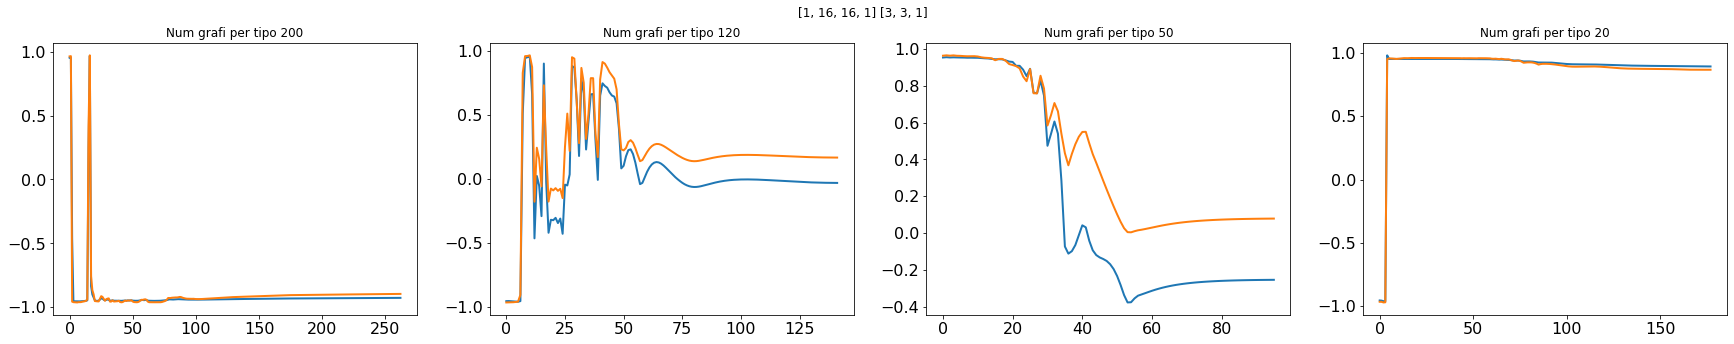

In [28]:
fig, axs = plt.subplots(1,4,figsize=(30,5))
for i, c in enumerate(configs[:4]):
    c_e_0 = c.conf['correlation_class0']
    axs[i].plot(c_e_0)
    c_e_1 = c.conf['correlation_class1']
    axs[i].plot(c_e_1)
    titolo = f"Num grafi per tipo {c.conf['graph_dataset']['Num_grafi_per_tipo']}"
    axs[i].set_title(titolo)

plt.suptitle(str(c.conf['model']['GCNneurons_per_layer']) + " " +  str(c.conf['model']['neurons_last_linear']))
plt.savefig("correlation_vs_epochs_numgrafi.png")
plt.show()

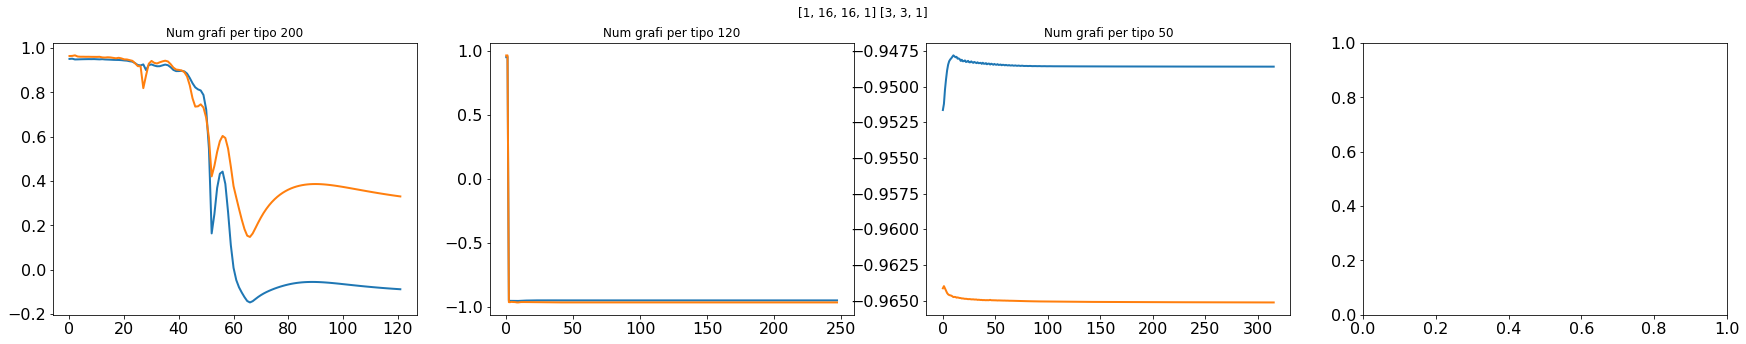

In [23]:
epoca=30
graph_embeddings_array = trainer.graph_embedding_per_epoch[epoca]
node_embeddings_array = trainer.node_embedding_per_epoch[epoca]
node_emb_pergraph, node_embedding_class = elaborate_embedding_pergraph(config_c, graph_embeddings_array, node_embeddings_array, [], trainer)
emb_perclass0, emb_perclass1 = separate_embedding_by_classes(node_emb_pergraph)


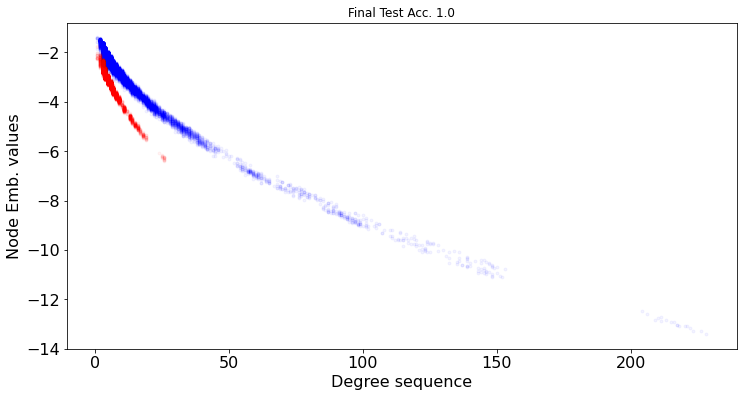

In [24]:
scatter_node_emb(emb_perclass0, emb_perclass1, trainer.last_accuracy)

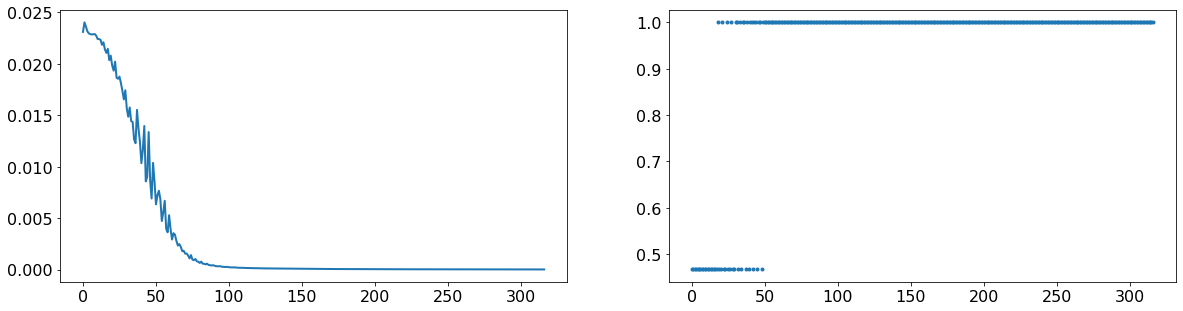

In [20]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,5))
ax1.plot(trainer.test_loss_list)
ax2.plot(trainer.accuracy_list, '.')

# Più di due classi

In [3]:
config_file = "configurations/classification_cm_manyclasses.yml"
config_c = Config(config_file)
dataset, model, trainer, config_c = init(config_file, parallel=True)

Create dataset
Generating dataset...
Dataset generated
Initialize model


In [5]:
trainer.load_dataset(dataset, percentage_train=config_c.conf['training']['percentage_train'], shuffle=True, parallel=False) 
trainer.launch_training()

100%|████████████████████████████████████████████████████████████████████████████████████| 800/800 [00:29<00:00, 27.37it/s]


Tempo impiegato: 29.320887565612793


In [19]:
epoca=180
graph_embeddings_array = trainer.graph_embedding_per_epoch[epoca]
node_embeddings_array = trainer.node_embedding_per_epoch[epoca]

node_emb_pergraph, node_embedding_class = elaborate_embedding_pergraph(config_c, graph_embeddings_array, node_embeddings_array, [], trainer)
embs_by_class = separate_embedding_by_classes(node_emb_pergraph)

In [20]:
len(embs_by_class)

8

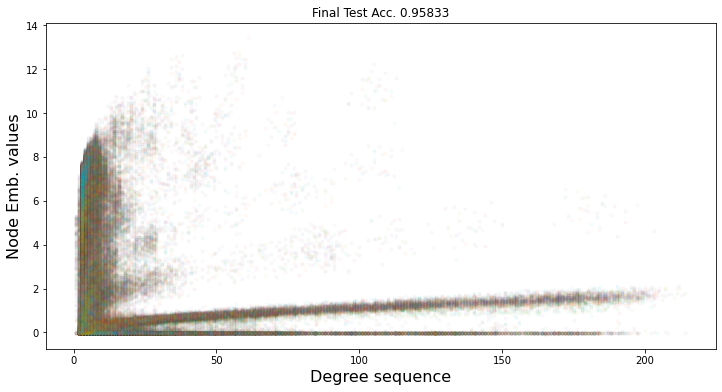

In [21]:
scatter_node_emb(embs_by_class, trainer.last_accuracy)

In [ ]:
experiments.t = trainer
experiments.c = config_c

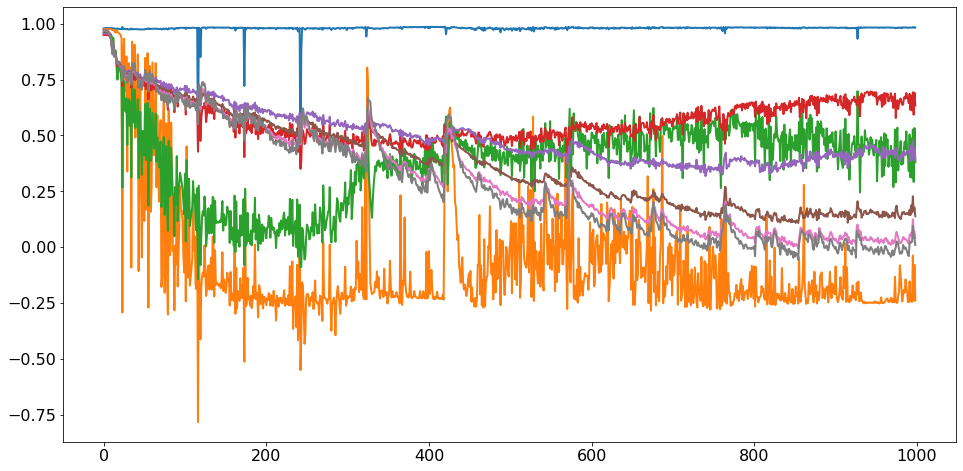

In [36]:
avg_corr_classes = get_corrs_training()
correlazioni = np.array(avg_corr_classes).T
for corr in correlazioni:
    plt.plot(corr)

### Freeze GCN layers

In [37]:
config_file = "configurations/classification_cm_manyclasses.yml"
config_c = Config(config_file)
dataset, model, trainer, config_c = init(config_file, parallel=True)

Create dataset
Generating dataset...
Dataset generated
Initialize model


In [38]:
trainer.load_dataset(dataset, percentage_train=config_c.conf['training']['percentage_train'], shuffle=True, parallel=False) 
trainer.launch_training()

100%|████████████████████████████████████████████████████████████████████████████████████| 800/800 [00:28<00:00, 28.42it/s]


Tempo impiegato: 28.31241488456726


In [45]:
epoca=1
graph_embeddings_array = trainer.graph_embedding_per_epoch[epoca]
node_embeddings_array = trainer.node_embedding_per_epoch[epoca]

node_emb_pergraph, node_embedding_class = elaborate_embedding_pergraph(config_c, graph_embeddings_array, node_embeddings_array, [], trainer)
embs_by_class = separate_embedding_by_classes(node_emb_pergraph)

In [46]:
embs_by_classT = np.array(embs_by_class).T

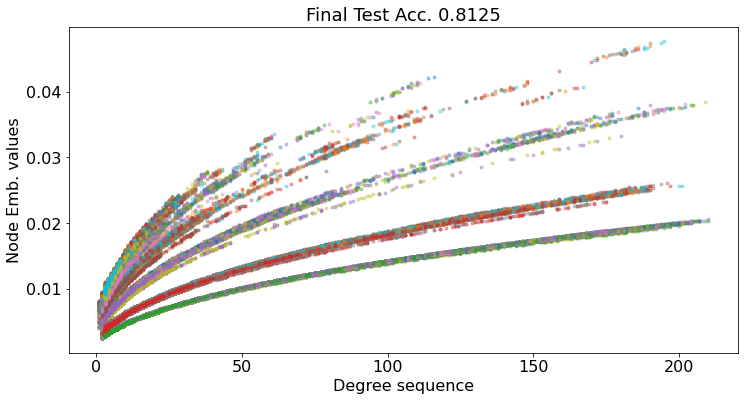

In [47]:
scatter_node_emb(embs_by_classT, trainer.last_accuracy)

In [ ]:
# provare a plottare la singola classe
# provare a confrontare con e senza l'intervallo di esponenti da -1 a -2 ... es.  [-2.5, -3.5, step 0.2]

In [43]:
experiments.t = trainer
experiments.c = config_c

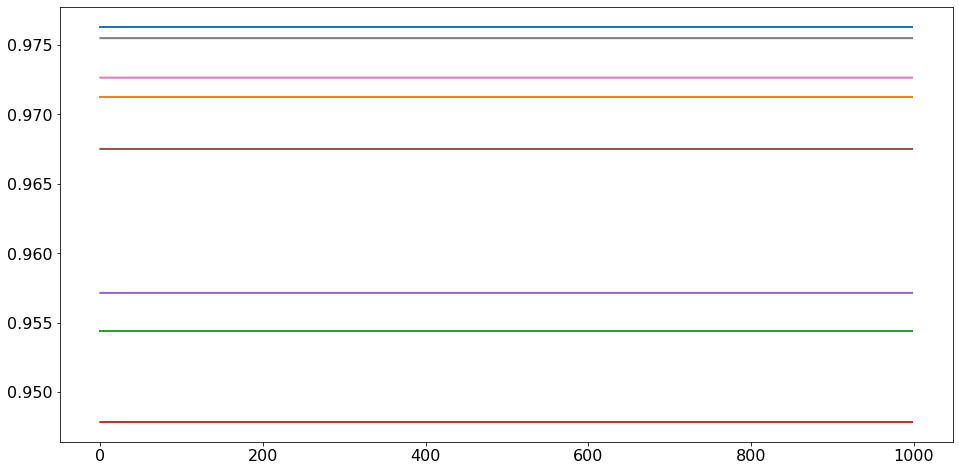

In [44]:
avg_corr_classes = get_corrs_training()
correlazioni = np.array(avg_corr_classes).T
for corr in correlazioni:
    plt.plot(corr)